In [1]:
from glob import glob
import os
from obspy import read, read_events, UTCDateTime, read_inventory

In [2]:
flist = glob("detections/2020*/*.xml")
#print(flist)

inv = read_inventory("downhole_geodes_ZNE.xml")
#print(inv)

In [4]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from obspy import Catalog

Ndeep_all = 0
Nshallow_all = 0

doplot = False

dirs = glob("detections/2020*")
dirs.sort()

for fdir in dirs:
    
    daystr = os.path.split(fdir)[1]
    print(daystr)
    
    catday = Catalog()
    
    flist = glob(os.path.join(fdir, "*.xml"))
    flist.sort()
    Ndeep = 0
    Nshallow = 0
        
    for f in flist:
        
        cat = read_events(f)
        

        for ev in cat:
            #print(ev)
            depths = []
            times = []
            for p in ev.picks:
                chid = "%s.%s..%s" % (p.waveform_id.network_code, p.waveform_id.station_code, p.waveform_id.channel_code)
                coords = inv.get_coordinates(chid)
                if p.phase_hint == "S":
                    depths.append(coords["local_depth"])
                    times.append(mdates.date2num(p.time._get_datetime()))
                    #print("%s: %s @ %f m" % (p.waveform_id.station_code, p.time, coords["local_depth"]))

            # Linear regression
            if depths and times:
                slope, intercept, r_value, p_value, std_err = stats.linregress(depths,times)
                if slope < 0 and p_value < 0.05:
                    #print(ev)
                    #print("p-value = %f, R value = %f" %(p_value, r_value))
                    #print(min([p.time for p in ev.picks]))

                    if doplot:                        
                        ax = plt.subplot(111)
                        ax.scatter(depths, times)
                        plt.show()
                        plt.close()

                    Ndeep += 1
                    catday += ev
                    
                else:
                    Nshallow += 1
        
    #print("Percentage of deep events = %4.1f\n\t# events shallow = %d\n\t# events deep = %d" % (Ndeep/(Nshallow+Ndeep)*100, Nshallow, Ndeep))
    
#     if len(catday.events) > 0:
        
#         fname = os.path.join("deep_events", "deep_events_day_%s.xml" % daystr)
#         catday.write(fname, format="QuakeML")
#         print("Wrote events to %s" % fname)
    Ndeep_all += Ndeep
    Nshallow_all += Nshallow
    
print(Ndeep_all)
print(Nshallow_all)
print(Ndeep_all/(Ndeep_all+Nshallow_all))

20200108
20200214
20200215
20200216
20200217
20200218
20200219
20200220
20200221
20200222
20200223
20200224
20200225
20200226
20200227
20200228
20200229
20200301
20200302
20200303
20200304
20200305
20200306
20200307
20200308
20200309
20200310
20200311
20200312
20200313
20200314
20200315
20200316
20200317
20200318
20200319
20200320
20200321
20200322
20200323
20200324
20200325
20200326
20200327
20200329
20200330
20200331
20200401
20200402
20200403
20200404
20200405
20200406
20200407
20200408
20200409
20200410
20200411
20200412
20200413
20200414
20200415
20200416
20200417
20200419
20200420
20200421
20200422
20200423
20200424
20200425
20200426
20200427
20200501
20200502
20200503
20200504
20200505
20200506
20200507
20200509
20200510
20200511
20200512
20200513
20200514
20200515
20200516
20200517
20200518
20200519
20200520
20200521
20200522
20200523
20200524
20200525
20200526
20200527
20200528
20200529
20200530
20200531
20200601
20200602
20200603
20200604
20200605
20200606
20200608
20200609
2

In [97]:
from obspy import Stream
import logging
Logger = logging.getLogger(__name__)

def get_stream(tmin, tmax, sampling_rate, process_length=6.0, m2nm=None, uniform_network=False):
    """
    Get stream for all stations found for a given time window.
    Look into both Hawk and Borehole data directories. Only keep DPN, DPE and DPZ channels.
    :param start_time: start time as UTCDateTime
    :param sampling_rate: Sampling rate
    :param process_length: Length of stream. Defaults to 3600 seconds.
    :param m2nm: Bool. Convert input data from m/s for nm/s (assumes input waveform as m/s or m)
    :param uniform_network: Bool. make network for all channels found equal to XX
    :return: Obspy stream

    NB: Make sur to check path to data!
    WF_DIR_ROOT_500Hz = "/home/gilbert_lab/cami_frs/borehole_data/sac_daily_nez_500Hz"
    WF_DIR_ROOT_HAWK = "/home/gilbert_lab/cami_frs/hawk_data/sac_data_mps/"
    """

    WF_DIR_ROOT_500Hz = "/home/gilbert_lab/cami_frs/borehole_data/sac_daily_nez_500Hz"
    WF_DIR_ROOT_HAWK = "/home/gilbert_lab/cami_frs/hawk_data/sac_data_mps/"

    stream_hour = Stream()
    pattern = os.path.join(WF_DIR_ROOT_500Hz, tmin.strftime("%Y%m%d"), "*DP*")
    Logger.info("Pattern to get hourly data for borehole: %s" % pattern)
    if glob(pattern):
        Logger.info("Number of files to read: %d" % len(glob(pattern)))
        tmp = read(pattern, starttime=tmin, endtime=tmax, nearest_sample=False)
        for tr in tmp:
            tr.stats.sampling_rate = round(tr.stats.sampling_rate)
        decfac = round(tmp[0].stats.sampling_rate / sampling_rate)
        Logger.info("Decimating by a factor of %d to get sampling rate of %f" % (decfac, sampling_rate))
        # Decimate
        tmp.decimate(decfac)
        tmp.detrend("demean")
        # Add
        stream_hour += tmp
        
    pattern_hawk = os.path.join(WF_DIR_ROOT_HAWK, "*", "*", "*DP[NEZ]*%s*" % tmin.strftime("%Y%m%d"))
    Logger.info("Pattern to get hourly data for hawks: %s" % pattern_hawk)
    if glob(pattern_hawk):
        Logger.info("Number of files to read: %d" % len(glob(pattern_hawk)))
        tmp = read(pattern_hawk, starttime=tmin, endtime=tmax, nearest_sample=False)
        for tr in tmp:
            tr.stats.sampling_rate = round(tr.stats.sampling_rate)
        decfac = round(tmp[0].stats.sampling_rate / sampling_rate)
        Logger.info("Decimating by a factor of %d to get sampling rate of %f" % (decfac, sampling_rate))
        # Decimate
        tmp.decimate(decfac)
        tmp.detrend("demean")
        # Add
        stream_hour += tmp

    if m2nm:  # Convert to nm/s
        #m2nm = 1e18 #1e9
        for tr in stream_hour:
            tr.data = tr.data * m2nm

    if uniform_network:
        for tr in stream_hour:
            tr.stats.network = "XX"

    return stream_hour


In [105]:
from matplotlib.dates import DateFormatter

def plot_3comps(st, picks=None, savename=None):
    stations = list(set([tr.stats.station for tr in st]))
    nsta = len(stations)
    tplt = st[0].times("matplotlib")

    fig, axs = plt.subplots(nsta, 3, sharex=True, figsize=(15, nsta*3))
    
    for i, sta in enumerate(stations):
            
        trn = st.select(station=sta, channel="DPN")[0]
        axs[i][0].plot_date(tplt, trn.data, "k")
        axs[i][0].set_title("%s" % trn.id)
        plt.xticks(rotation=45)
        tre = st.select(station=sta, channel="DPE")[0]
        axs[i][1].plot_date(tplt, tre.data, "k")
        axs[i][1].set_title("%s" % tre.id)
        plt.xticks(rotation=45)
        trz = st.select(station=sta, channel="DPZ")[0]
        axs[i][2].plot_date(tplt, trz.data, "k")
        axs[i][2].set_title("%s" % trz.id)
        plt.xticks(rotation=45)
        
        if picks:
            stapicks = [p for p in picks if p.waveform_id.station_code == sta]
            for sp in stapicks:
                axs[i][0].axvline(x=mdates.date2num(sp.time._get_datetime()), color="r")
                axs[i][1].axvline(x=mdates.date2num(sp.time._get_datetime()), color="r")
                axs[i][2].axvline(x=mdates.date2num(sp.time._get_datetime()), color="r")
                
    plt.xticks(rotation=45)
    fig.autofmt_xdate()
    
    plt.suptitle("%s - %s" % (st[0].stats.starttime.strftime("%Y-%m-%d %H:%M:%S"), 
                              st[0].stats.endtime.strftime("%Y-%m-%d %H:%M:%S")))
    
    if savename:
        plt.savefig(savename, format="PNG")
        
    
    plt.show()
    plt.close()

Event:	

	 resource_id: ResourceIdentifier(id="smi:local/554eab11-bec0-4610-aec2-a83703e4b756")
	        ---------
	       picks: 6 Elements
108 Trace(s) in Stream:

BH.G1..DPE | 2020-03-10T00:31:34.134116Z - 2020-03-10T00:31:40.146116Z | 250.0 Hz, 1504 samples
...
(106 other traces)
...
X7.F0901..DPZ | 2020-03-10T00:31:34.136116Z - 2020-03-10T00:31:40.144116Z | 250.0 Hz, 1503 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


ValueError: x and y must have same first dimension, but have shapes (1504,) and (1503,)

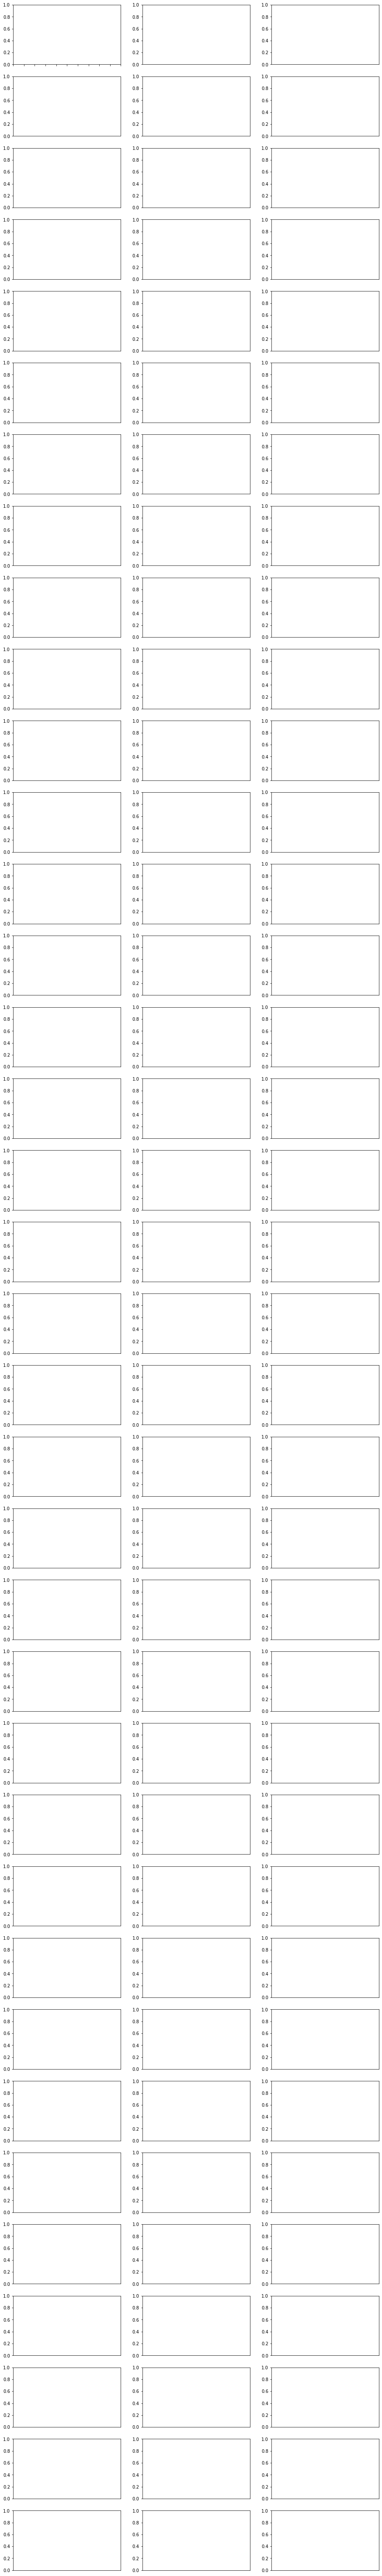

In [114]:
prepick = 3.0
postpick = 3.0

flist = glob("deep_events/*20200310.xml")
flist.sort()
for f in flist:
    
    catday = read_events(f)
    
    for ev in catday:
        print(ev)
        
        tmin = min([p.time for p in ev.picks])
        tmax = max([p.time for p in ev.picks])
        
        start_time = tmin - 3.0
        end_time = tmax + 3.0
        
        st = get_stream(tmin=start_time, tmax=end_time, sampling_rate=250.0)
        print(st)
        st.filter("lowpass", freq=60)
        
        plot_3comps(st, picks=ev.picks, savename=None)

In [17]:
from obspy.clients.fdsn.client import Client
client = Client("IRIS")
t1 = UTCDateTime(2020,10,26,19,0,0)
t2 = UTCDateTime(2020,10,26,21,0,0)
cat = client.get_events(starttime=t1, endtime=t2, 
                        minmagnitude=3, 
                         latitude=50.450543, 
                         longitude=-112.120657, 
                         minradius=1, maxradius=90)

for ev in cat:
    print(ev.origins[0].time)

2020-10-26T19:51:05.890000Z
